In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir('/home/sebastiaan/PhD/Repositories/immune_response_detection/')

from sklearn.metrics import auc
from Levenshtein import distance as levenshtein_distance
from raptcr.constants.parsing import parse_yfv_repertoires
from raptcr.indexing import FlatIndex
from raptcr.hashing import TCRDistEncoder
from raptcr.background import SyntheticBackground
from raptcr.neighbors import NeighborEnrichment
from raptcr.background import generate_olga_sequences_multi
from raptcr.neighbors import tcr_dict_to_df, index_neighbors

plt.rcParams["font.family"] = "monospace"

Read YFV repertoires

In [53]:
day_15 = parse_yfv_repertoires("./data/yfv/P1_15_F1_.txt.gz")

encoder = TCRDistEncoder(aa_dim=8, full_tcr=True)
neighbor_counter = NeighborEnrichment(repertoire=day_15, hasher=encoder, radius=12.5)
neighbor_counter.compute_neighbors()

In [120]:
df = pd.read_csv("/home/sebastiaan/Desktop/P1_15_F1_vcdr3.txt", sep='\t')
df["v_call"] = df.v_call.apply(lambda x: x.split("*")[0]+"*01")
df["j_call"] = df.j_call.apply(lambda x: x.split("*")[0]+"*01")
df.to_csv("/home/sebastiaan/Desktop/P1_15_F1_vcdr3.txt", sep='\t' ,index=False)

Perform enrichment analysis against pre-vaccination repertoire

In [11]:
print("Reading input")
day_pre0 = parse_yfv_repertoires("./data/yfv/P1_pre0_F1_.txt.gz")

print("Building index")
encoder = TCRDistEncoder(aa_dim=8, full_tcr=True).fit()
index = FlatIndex(hasher=encoder)
index.add(day_pre0)
neighbor_counter.bg_index = index

print("Determining hits")
p = neighbor_counter.compute_pvalues(prefilter=False)

Reading input
Building index
Determining hits
Using background of size 186084.
Computing neighbor counts in background for 74889 sequences.
Performing hypergeometric testing.


Function to extract FPR and TPR from annotated dataframe.

In [106]:
def get_metrics(df, target_col="responding"):
    fp = 0
    tp = 0
    fpr = []
    tpr = []
    for i in df[target_col]:
        if i == False:
            fp += 1
        else:
            tp += 1
        fpr.append(fp)
        tpr.append(tp)
    N = df[target_col].value_counts()[False]
    P = df[target_col].value_counts()[True]
    fpr = [i/N for i in fpr]
    tpr = [i/P for i in tpr]
    return fpr, tpr

def annotate_results(df, responding):
    df["v_gene"] = df.v_call.apply(lambda x: x.split("*")[0])
    df = df.merge(responding, on=["junction_aa","v_gene"], how="left")
    df["responding"] = df["responding"].fillna("grey")
    df["responding"] = df.responding.map({"red":True,"grey":False})
    return df

def identify_neighbors(n, d=1):
    if n > d:
        return False
    else:
        return True

def get_distance_from_responding(df):
    lds = []
    for i in range(len(df)):
        seq = df.iloc[i]
        cdr3 = seq["junction_aa"]
        v = seq["v_gene"]
        vsub = responding[responding.v_gene==v]
        try:
            lds.append(min([levenshtein_distance(cdr3,j) for j in vsub.junction_aa]))
        except ValueError:
            lds.append(None)
    df['ld'] = lds
    df["hit"] = df.ld.apply(lambda x: identify_neighbors(x))
    return df

### Evaluate performance

Get list of vaccine-responding clones

In [18]:
responding = pd.read_csv("./analysis/background_testing/yfv/yfv_responding.txt", sep="\t")
responding = responding[["bestVGene","CDR3.amino.acid.sequence"]].drop_duplicates()
responding.columns = ["v_gene","junction_aa"]
responding["responding"] = "red"
responding.head()

,v_gene,junction_aa,responding
0,TRBV4-2,CASSQGTAYEQYF,red
1,TRBV4-3,CASSHATGPYEQYF,red
2,TRBV27,CASSYGQGSSYEQYF,red
3,TRBV9,CASSSGTSEGAYEQYF,red
4,TRBV2,CASNRGGGSYEQYF,red


Create a random baseline by randomly selecting a set of sequences from the repertoire.

In [112]:
baseline = day_15.sample(p.shape[0])
baseline_annot = annotate_results(baseline, responding)
baseline_annot.head()

,junction_aa,junction,v_call,j_call,clonotype_id,clone_count,clone_fraction,v_gene,responding
0,CASSLVPGLQETQYF,TGCGCCAGCAGCTTGGTACCGGGACTTCAAGAGACCCAGTACTTC,TRBV5-1*01,TRBJ2-5*01,25914,5,0.000003,TRBV5-1,False
1,CASSLGTSGNTGELFF,TGTGCCAGCAGCTTGGGGACTAGCGGGAACACCGGGGAGCTGTTTTTT,TRBV5-5*01,TRBJ2-2*01,158638,2,0.000001,TRBV5-5,False
2,CASSPGQGVIHGYTF,TGTGCCAGCAGCCCTGGACAGGGGGTAATTCATGGCTACACCTTC,TRBV27*01,TRBJ1-2*01,80788,3,0.000002,TRBV27,False
3,CAIRDPTGPVNEQFF,TGTGCCATCAGGGACCCGACGGGGCCAGTGAATGAGCAGTTCTTC,TRBV10-3*01,TRBJ2-1*01,73643,3,0.000002,TRBV10-3,False
4,CASAPGTGALNYGYTF,TGTGCCAGCGCCCCCGGGACAGGGGCCCTAAACTATGGCTACACCTTC,TRBV12-3*01,TRBJ1-2*01,64682,3,0.000002,TRBV12-3,False


**PRE-VAX SAMPLE**

In [111]:
p_annot = annotate_results(p,responding)
p_annot.head()

,v_call,junction_aa,foreground_neighbors,background_neighbors,pval,v_gene,responding
0,TRBV20-1*01,CSAREGGNTEAFF,63,2,2.821133e-11,TRBV20-1,False
1,TRBV20-1*01,CSAREGGVTEAFF,50,1,8.811176e-10,TRBV20-1,False
2,TRBV20-1*01,CSAREGGDTEAFF,46,1,5.484972e-09,TRBV20-1,False
3,TRBV20-1*01,CSAREGGITEAFF,46,1,5.484972e-09,TRBV20-1,False
4,TRBV20-1*01,CSARDGGNTEAFF,35,1,8.054828e-07,TRBV20-1,False


**OLGA V-CDR3 background** \
q = 1

In [133]:
vhits_1 = pd.read_csv("./analysis/test/vmatch/P1_15_F1_vcdr3q1_hits.txt", sep="\t")
vhits_1_annot = annotate_results(df=vhits_1, responding=responding)
vhits_1_annot.head()

,Unnamed: 0,v_call,junction_aa,foreground_neighbors,background_neighbors,pval,v_gene,responding
0,45375,TRBV20-1*01,CSAREGGITEAFF,46,7,9.987535e-41,TRBV20-1,False
1,9945,TRBV20-1*01,CSAREGGATEAFF,45,6,1.409472e-40,TRBV20-1,False
2,1269,TRBV20-1*01,CSAREGGVTEAFF,50,14,1.100314e-39,TRBV20-1,False
3,5867,TRBV20-1*01,CSAREGGNTEAFF,63,43,4.182104e-38,TRBV20-1,False
4,20030,TRBV20-1*01,CSAREGGWTEAFF,37,1,1.016866e-37,TRBV20-1,False


q = 10

In [134]:
vhits_10 = pd.read_csv("./analysis/test/vmatch/P1_15_F1_vcdr3q10_hits.txt", sep="\t")
vhits_10_annot = annotate_results(df=vhits_10, responding=responding)
vhits_10_annot.head()

,Unnamed: 0,v_call,junction_aa,foreground_neighbors,background_neighbors,pval,v_gene,responding
0,20030,TRBV20-1*01,CSAREGGWTEAFF,37,10,6.019410e-30,TRBV20-1,False
1,9945,TRBV20-1*01,CSAREGGATEAFF,45,60,5.613919e-20,TRBV20-1,False
2,45377,TRBV20-1*01,CSAREGGISEAFF,30,20,4.286050e-19,TRBV20-1,False
3,45375,TRBV20-1*01,CSAREGGITEAFF,46,70,9.523963e-19,TRBV20-1,False
4,5847,TRBV20-1*01,CSARNSGGTEAFF,23,10,4.155415e-17,TRBV20-1,False


**SHUFFLED BACKGROUND**

In [168]:
shuff = pd.read_csv(f'./analysis/test/shuff/P1_15_F1_shuff_hits.txt', sep="\t")
shuff_annot = annotate_results(df=shuff, responding=responding)
shuff_annot.head()

,Unnamed: 0,v_call,junction_aa,foreground_neighbors,background_neighbors,pval,v_gene,responding
0,12310,TRBV20-1*01,CSAREGGATEAFF,45,32,3.212015e-27,TRBV20-1,False
1,56940,TRBV20-1*01,CSAREGGITEAFF,46,35,4.874502e-27,TRBV20-1,False
2,1676,TRBV20-1*01,CSAREGGVTEAFF,50,57,4.157352e-24,TRBV20-1,False
3,855,TRBV20-1*01,CSAREGGTTEAFF,40,30,7.543905e-24,TRBV20-1,False
4,56943,TRBV20-1*01,CSAREGGISEAFF,30,12,2.097665e-22,TRBV20-1,False


Compute (edit-)distances to the YFV-responding clones identified in Pogorelyy et al. We first match to the V gene and then identify the closest distance to the YFV-responding clones.

In [ ]:
baseline = get_distance_from_responding(baseline)
p = get_distance_from_responding(p)
vhits_1 = get_distance_from_responding(vhits_1)
vhits_10 = get_distance_from_responding(vhits_10)
shuff = get_distance_from_responding(shuff)

### Plot results

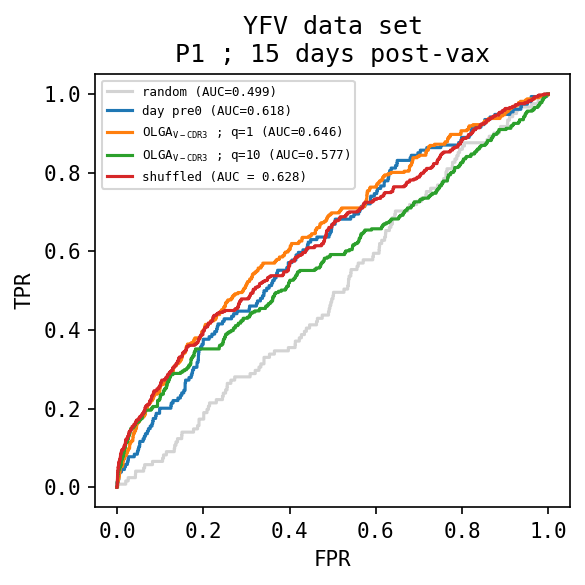

In [169]:
fig, ax = plt.subplots(dpi=150, figsize=(4,4))

fpr, tpr = get_metrics(baseline_annot)
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, c="lightgrey", label=f"random (AUC={auroc})")

fpr, tpr = get_metrics(p_annot)
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"day pre0 (AUC={auroc})")

fpr, tpr = get_metrics(vhits_1_annot)
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=1 (AUC=%s)" % (auroc))

fpr, tpr = get_metrics(vhits_10_annot)
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=10 (AUC=%s)" % (auroc))

fpr, tpr = get_metrics(shuff_annot)
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"shuffled (AUC = {auroc})")

ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("YFV data set\nP1 ; 15 days post-vax")
ax.legend(fontsize=6)
fig.tight_layout()

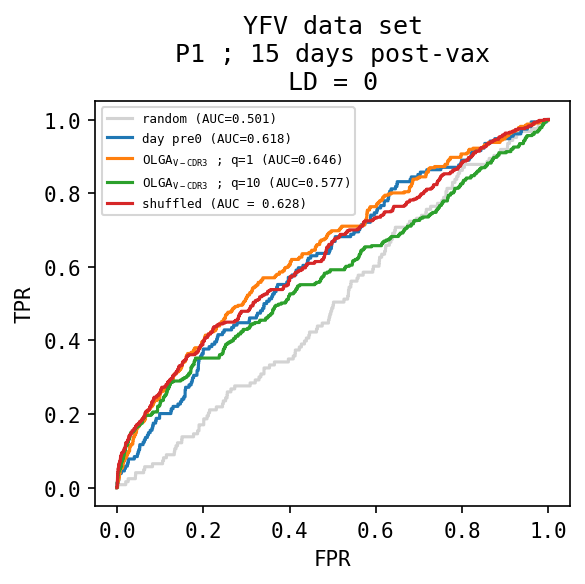

In [220]:
cutoff = 0

fig, ax = plt.subplots(dpi=150, figsize=(4,4))

baseline["hit"] = baseline.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(baseline, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, c="lightgrey", label=f"random (AUC={auroc})")

p["hit"] = p.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(p, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"day pre0 (AUC={auroc})")

vhits_1["hit"] = vhits_1.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(vhits_1, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=1 (AUC=%s)" % (auroc))

vhits_10["hit"] = vhits_10.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(vhits_10, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=10 (AUC=%s)" % (auroc))

shuff["hit"] = shuff.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(shuff, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"shuffled (AUC = {auroc})")

ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title(f"YFV data set\nP1 ; 15 days post-vax\nLD = {cutoff}")
ax.legend(fontsize=6)
fig.tight_layout()
fig.savefig("./fig/roc_auc_P1_15_LD_0.png", format="png", dpi=500)

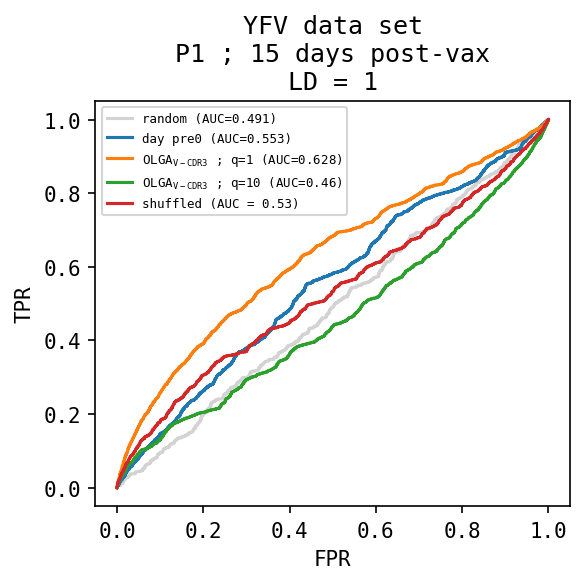

In [221]:
cutoff = 1

fig, ax = plt.subplots(dpi=150, figsize=(4,4))

baseline["hit"] = baseline.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(baseline, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, c="lightgrey", label=f"random (AUC={auroc})")

p["hit"] = p.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(p, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"day pre0 (AUC={auroc})")

vhits_1["hit"] = vhits_1.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(vhits_1, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=1 (AUC=%s)" % (auroc))

vhits_10["hit"] = vhits_10.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(vhits_10, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=10 (AUC=%s)" % (auroc))

shuff["hit"] = shuff.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(shuff, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"shuffled (AUC = {auroc})")

ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title(f"YFV data set\nP1 ; 15 days post-vax\nLD = {cutoff}")
ax.legend(fontsize=6)
fig.tight_layout()
fig.savefig("./fig/roc_auc_P1_15_LD_1.png", format="png", dpi=500)

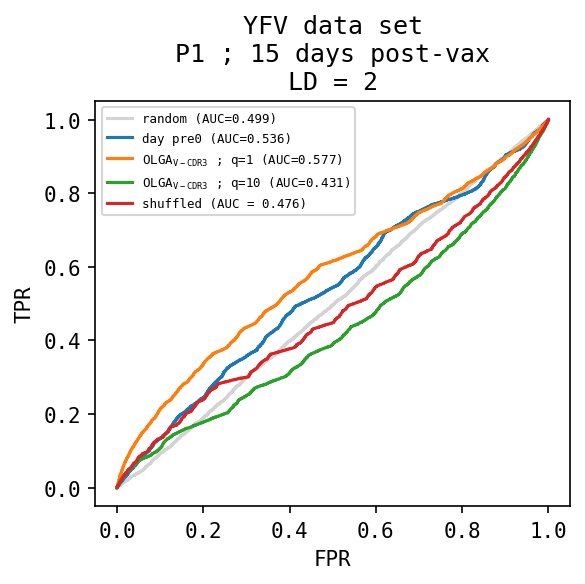

In [222]:
cutoff = 2

fig, ax = plt.subplots(dpi=150, figsize=(4,4))

baseline["hit"] = baseline.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(baseline, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, c="lightgrey", label=f"random (AUC={auroc})")

p["hit"] = p.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(p, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"day pre0 (AUC={auroc})")

vhits_1["hit"] = vhits_1.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(vhits_1, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=1 (AUC=%s)" % (auroc))

vhits_10["hit"] = vhits_10.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(vhits_10, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=r"$\mathregular{OLGA_{V-CDR3}}$ ; q=10 (AUC=%s)" % (auroc))

shuff["hit"] = shuff.ld.apply(lambda x: identify_neighbors(x, d=cutoff))
fpr, tpr = get_metrics(shuff, target_col="hit")
auroc = np.round(auc(fpr,tpr),3)
ax.plot(fpr, tpr, label=f"shuffled (AUC = {auroc})")

ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title(f"YFV data set\nP1 ; 15 days post-vax\nLD = {cutoff}")
ax.legend(fontsize=6)
fig.tight_layout()
fig.savefig("./fig/roc_auc_P1_15_LD_2.png", format="png", dpi=500)